In [1]:
import ray
import numpy as np
import matplotlib.pyplot as plt
from environment import SimpleEnv
from ray_gnn import New_MPNNModel
from ray import tune, air
from ray.tune.registry import register_env
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.pre_checks.env import check_env
from ray.rllib.algorithms.ppo import PPOConfig

episode: 0
cumulative reward: -10


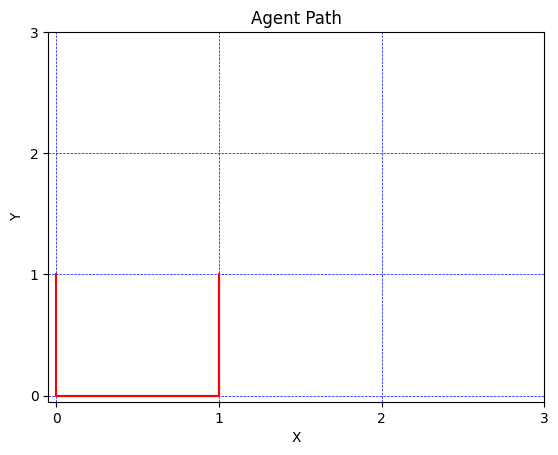

In [2]:
# instantiate the env
length, width, capacity = 4, 4, 2
edge_capacity = np.full((length,width,4),capacity)
nets = [(0,0), (3,2)]
macros = []
env= SimpleEnv(length, width, nets, macros, edge_capacity)
num_episodes = 1

# render the env with random moves
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = env.action_space.sample()
        new_obs, reward, done, info = env.step(action)
        total_reward += reward

        if done:
            break

    print(f"episode: {ep}")
    print(f"cumulative reward: {total_reward}")
    env.render()

In [3]:
# register and check the env
register_env("simple_env", lambda config: SimpleEnv(length, width, nets, macros, edge_capacity))

print("checking environment ...")
try:
    check_env(env)
    print("All checks passed. No errors found.")
except:
    print("failed")
    print(check_env(env))

# register the custom model
ModelCatalog.register_custom_model("custom_mpnn", MPNNModel)

2023-11-25 13:21:30,813	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


checking environment ...
All checks passed. No errors found.


/home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


In [4]:
# config everything
config = (
    PPOConfig()
    .environment(env = "simple_env")
    .framework(framework="torch")
    .evaluation(
        evaluation_interval=15, 
        evaluation_duration=5,      
        evaluation_num_workers=2,  #0 for Colab
        evaluation_parallel_to_training=True, #False for Colab
        evaluation_config = dict(
            explore=False,
            num_workers=1
        ))
    .rollouts(
    num_rollout_workers=2, #1 for Colab
    num_envs_per_worker=1)
    .training(
        model={
            "custom_model": "custom_mpnn",
            "custom_model_config": {  # This is the additional configuration for your model
            "node_features_dim": 2,  # Replace with your actual value
            "edge_features_dim": 1,  # Replace with your actual value
            "action_space_dim": 4,  # Replace with your actual value
            "diameter": length + width - 2
            # Add other necessary configurations specific to your model
            }
        }#,
        #_enable_learner_api=False
    )
)
#config.rl_module(_enable_rl_module_api=False)
stop_criteria = dict(training_iteration = 20)
tuner = tune.Tuner(
    config.algo_class,
    param_space = config.to_dict(),
    run_config = air.RunConfig(
        local_dir = "/home/brucexi2/UBC-EECE571F/checkpoint/trial",
        stop = stop_criteria,
        verbose = 2,
        checkpoint_config=air.CheckpointConfig(checkpoint_at_end=True)
    )
)
#algo = config.build()

In [5]:
experiment_results = tuner.fit()

2023-11-25 13:21:48,908	INFO worker.py:1538 -- Started a local Ray instance.


(raylet) /home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/dashboard/agent.py:51: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(PPO pid=69850) 2023-11-25 13:21:53,348	WARNING algorithm_config.py:488 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
(PPO pid=69850) 2023-11-25 13:21:53,841	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=69910) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=69910)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=69910) 2023-11-25 13:21:57,971	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=69909) 2023-11-25 13:21:58,013	WARNIN

Trial name
PPO_simple_env_a551b_00000


(PPO pid=69850) 2023-11-25 13:22:02,860	WARNING util.py:66 -- Install gputil for GPU system monitoring.
(PPO pid=69850) 2023-11-25 13:22:02,899	ERROR actor_manager.py:486 -- Ray error, taking actor 1 out of service. ray::RolloutWorker.apply() (pid=69909, ip=10.0.0.82, repr=<ray.rllib.evaluation.rollout_worker.RolloutWorker object at 0x7f1a382989a0>)
(PPO pid=69850)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 183, in apply
(PPO pid=69850)     raise e
(PPO pid=69850)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib/utils/actor_manager.py", line 174, in apply
(PPO pid=69850)     return func(self, *args, **kwargs)
(PPO pid=69850)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rllib/execution/rollout_ops.py", line 86, in <lambda>
(PPO pid=69850)     lambda w: w.sample(), local_worker=False, healthy_only=True
(PPO pid=69850)   File "/home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/rll

In [12]:
ckpt = "/home/brucexi2/UBC-EECE571F/checkpoint/trial/PPO_2023-11-24_10-18-08/PPO_simple_env_d7cbc_00000_0_2023-11-24_10-18-18/checkpoint_000020"
algo = config.build()
algo.restore(ckpt)

2023-11-24 12:24:47,102	INFO algorithm.py:501 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=11991) 2023-11-24 12:24:50,975	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=11991) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=11991)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=11991) 2023-11-24 12:24:50,984	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=11992) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.p

2023-11-24 13:58:23,815	INFO worker.py:1538 -- Started a local Ray instance.
(raylet) /home/brucexi2/anaconda3/lib/python3.10/site-packages/ray/dashboard/agent.py:51: DeprecationWarning: There is no current event loop
(raylet)   aiogrpc.init_grpc_aio()
(RolloutWorker pid=21187) 2023-11-24 13:58:28,595	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
(RolloutWorker pid=21187) /home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=21187)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=21187) 2023-11-24 13:58:28,603	WARNING catalog.py:637 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(Rol

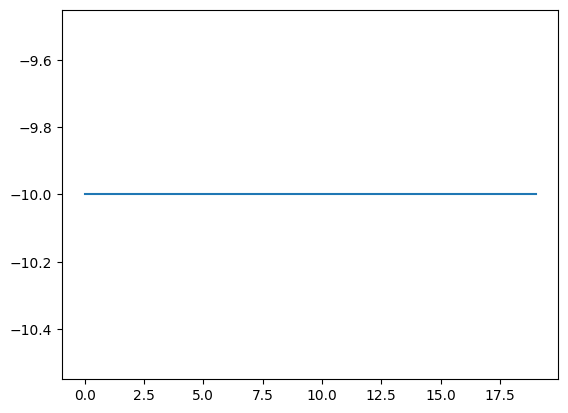

In [6]:
# train the policy for 10 iterations, also plot the mean reward vs iteration 
algo = config.build()
rewards = []
for i in range (20):
    result = algo.train()
    rewards.append(result["episode_reward_mean"])
plt.plot(rewards)
plt.show()

3
3
3
3
3
3
3
3
3
3
cumulative reward: -10


/home/brucexi2/anaconda3/lib/python3.10/site-packages/gym/spaces/box.py:142: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")


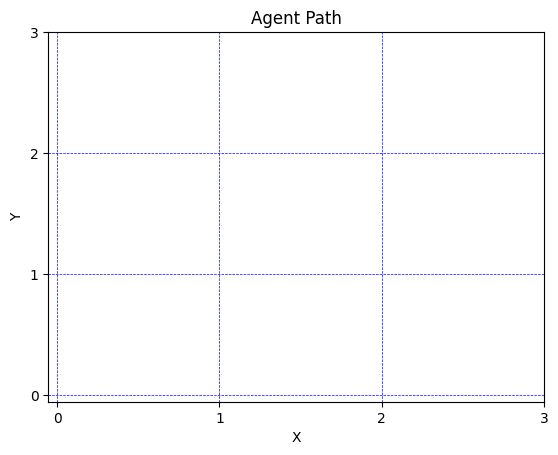

In [7]:
# run inference
num_episodes = 1
env= SimpleEnv(length, width, [(0,0), (3,2)], macros, edge_capacity)
for ep in range(num_episodes):
    total_reward = 0
    obs = env.reset()
    done = False
    while True:
        action = algo.compute_single_action(observation=obs)
        print(action)
        obs, reward, done, info = env.step(action)
        #print(obs)
        total_reward += reward
        
        if done:
            break
        
    print(f"cumulative reward: {total_reward}")
    env.render()

In [ ]:
# release the resources
algo.stop()
ray.shutdown()